<a href="https://colab.research.google.com/github/YXIE1010/ML2/blob/main/ml2_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML2 Example Training Notebook**
This Jupyter Notebook briefly describes the framework to train the U-Net model in the ML2 project, i.e., Machine Learning based Melting Layer Detection. The neural network training is implemented with Tensorflow.   




## Import libraries   
First, we start with loading modules used in this project.

In [2]:
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

## Load datasets
We use preprocessed datasets to train, validate and test the U-Net model.   
Note that     
(1) The number of cases with and without melting layers are equal to generate a balanced dataset for model training.  
(2) We used a part of the total data to efficiently illustrate the training process.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks


In [4]:
# load datasets
fpathin = os.getcwd() + '/data/'
fpathout = os.getcwd() + '/output/'

In [5]:
# access the data files with memory-map mode
data_train0 = np.load(fpathin + 'training.npy', mmap_mode='r' )
data_val0 = np.load(fpathin + 'validation.npy', mmap_mode='r' )
data_test0 = np.load(fpathin + 'testing.npy', mmap_mode='r' )

In [6]:
# find cases with melting layers
idml_train = np.where( np.sum(data_train0[:,:,:,3], axis=(1,2))>0 )[0]
idml_val = np.where( np.sum(data_val0[:,:,:,3], axis=(1,2))>0 )[0]
idml_test = np.where( np.sum(data_test0[:,:,:,3], axis=(1,2))>0 )[0]

# find the index of cases w/o melting layer
idno_train = np.setdiff1d( np.arange(0, data_train0.shape[0]), idml_train )
idno_val = np.setdiff1d( np.arange(0, data_val0.shape[0]), idml_val )
idno_test = np.setdiff1d( np.arange(0, data_test0.shape[0]), idml_test )

# set a fixed random seed
np.random.seed(41)
np.random.shuffle(idml_train)
np.random.shuffle(idml_val)
np.random.shuffle(idml_test)
np.random.shuffle(idno_train)
np.random.shuffle(idno_val)
np.random.shuffle(idno_test)

In [7]:
# combine the melting layer cases with no melting layer cases
# same size for both category to generate a balanced dataset
# include a part of the total data
id_train = np.concatenate( (idml_train[0:250], idno_train[0:250]), axis=0 )
id_val = np.concatenate( (idml_val[0:20], idno_val[0:20]), axis=0 )
id_test = np.concatenate( (idml_test[0:25], idno_test[0:25]), axis=0 )

In [8]:
data_train0 = data_train0[id_train, :, :, :]
data_val0 = data_val0[id_val, :, :, :]
data_test0 = data_test0[id_test, :, :, :]

In [9]:
# separate the input features and output targets
# for the training, validation, testing datasets

train_input = data_train0[:, :, :, 0:3]
train_target = data_train0[:, :, :, 3]

val_input = data_val0[:, :, :, 0:3]
val_target = data_val0[:, :, :, 3]

test_input = data_test0[:, :, :, 0:3]
test_target = data_test0[:, :, :, 3]

In [10]:
# make the dimension 1 stands out
train_target = train_target[:, :, :, np.newaxis]
val_target = val_target[:, :, :, np.newaxis]
test_target = test_target[:, :, :, np.newaxis]


In [11]:
# choose some samples for sanity check
sample_input = test_input[[10,20,30,40], :, :, :]
sample_target = test_target[[10,20,30,40], :, :, :]

In [12]:
del data_train0, data_val0, data_test0

## Define custom metrics and functions
Here we add some tools to help train the model, including the Intersection over Union (IoU) metric, Dice coefficient, and a combo loss function of Binary Cross Entropy (BCE) and Dice coefficient loss.

In [13]:
# Define the custom metrics
def iou(y_true, y_pred, smooth=1):
    """
    Calculate intersection over union (IoU) between images.
    Input shape : Batch x Height x Width x #Classes (BxHxWxN), N = 1 in our binary classification case
    Input value : 0 - w/o melting layer or 1 - with melting layer
    Using mean as reduction type for batch values.
    """
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3])
    union = union - intersection
    ## calculate the intersection over union index
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

    return iou


def dice_coef(y_true, y_pred, smooth=1.e-9):
    """
    Calculate dice coefficient: evaluate the similarity between two datasets
    Input shape should be Batch x Height x Width x #Classes (BxHxWxN).
    Using Mean as reduction type for batch values.
    """
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))

    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice_score = K.mean((2 * intersection + smooth) / (union + smooth), axis=0)

    return dice_score


# Define the custom loss function
def dice_loss(y_true, y_pred,smooth=1.e-9):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    dice = ( numerator + smooth) / (denominator + smooth)
    return 1 - dice


def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, axis=[1,2,3])
    dice = dice_loss(y_true, y_pred)
    return bce + dice


Define the functions to binarize model output probability and visualize the prediction results of the sample cases

In [14]:
#%% Define a function to create masks based on predicted data
def create_mask(data_predict):
    pred_mask = np.zeros(data_predict.shape)
    pred_mask[data_predict>0.5] = 1   # Probability larger than 0.5

    return pred_mask

#%% Define a function for visualization
def display(iepoch, data_input, data_target, data_predict):
    data_mask = create_mask(data_predict)
    for icase in range(data_input.shape[0]):
        plt.figure(figsize=(12,2.5), dpi=150)
        plt.suptitle('Sample #' + '{:02d}'.format(icase+1) + ' @ Epoch #'+ '{:02d}'.format(iepoch), fontsize=8)

        plt.subplot(1,4,1)
        pc1 = plt.pcolormesh(np.arange(0,256), np.arange(0,256)/256*8, data_input[icase,:,:,2],cmap = cm.RdBu_r, vmin=-0.5, vmax=0.5)
        plt.xlabel('Time (seconds)', fontsize=8)
        plt.ylabel('Height AGL (km)', fontsize=8)
        plt.title('Input standardized dVd', fontsize=8)
        cb1 = plt.colorbar(pc1)
        cb1.ax.tick_params(labelsize=7)

        plt.subplot(1,4,2)
        pc2 = plt.pcolormesh(np.arange(0,256), np.arange(0,256)/256*8, data_target[icase,:,:,0], vmin=0, vmax=1)
        plt.xlabel('Time (seconds)', fontsize=8)
        #plt.ylabel('Height AGL (km)', fontsize=8)
        plt.title('True Mask', fontsize=8)
        cb2 = plt.colorbar(pc2)
        cb2.ax.tick_params(labelsize=7)

        plt.subplot(1,4,3)
        pc3 = plt.pcolormesh(np.arange(0,256), np.arange(0,256)/256*8, data_predict[icase,:,:,0], vmin=0.3, vmax=0.7)
        plt.xlabel('Time (seconds)', fontsize=8)
        #plt.ylabel('Height AGL (km)', fontsize=8)
        plt.title('Predicted Prob', fontsize=8)
        cb3 = plt.colorbar(pc3)
        cb3.ax.tick_params(labelsize=7)

        plt.subplot(1,4,4)
        pc4 = plt.pcolormesh(np.arange(0,256), np.arange(0,256)/256*8, data_mask[icase,:,:,0], vmin=0, vmax=1)
        plt.xlabel('Time (seconds)', fontsize=8)
        #plt.ylabel('Height AGL (km)', fontsize=8)
        plt.title('Predicted Mask', fontsize=8)
        cb4 = plt.colorbar(pc4)
        cb4.ax.tick_params(labelsize=7)

        plt.show()
        plt.close()

## Develop the U-Net model
This submodule shows how to implement U-Net models with adjustable layer depth.

In [15]:
# Define the Unet Model in modules
def enblock(x, filters, dropout):
    x = keras.layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same", strides=2)(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(dropout)(x, training=False)
    return x

def deblock(x, filters, eskipconnet, dropout):
    x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=(3,3), padding="same")(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=(3,3), padding="same", strides=2)(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = keras.layers.Activation('relu')(x)
    # apply skip connection
    x = keras.layers.Concatenate()([x, eskipconnet])
    x = keras.layers.Dropout(dropout)(x, training=False)
    return x

def unet(input_size, output_channels, depth=4):
    # start with the input layer
    input_layer = keras.Input(shape=input_size, name="input_layer")

    # define the encoder layers (Downward)
    encoders = []
    for i in range(0, depth):
        if i == 0:
            e = enblock(input_layer, filters*(2**i), DROP_RATE)
        else:
            e = enblock(encoders[i-1], filters*(2**i), DROP_RATE)
        encoders.append(e)

    # defind the decoder layers (Upward)
    decoders = []
    for ii in reversed(range(0, depth-1)):
        if ii == depth-2:
            d = deblock(encoders[ii+1], filters*(2**(ii+1)), encoders[ii], DROP_RATE)
        else:
            d = deblock(decoders[depth-3-ii], filters*(2**(ii+1)), encoders[ii], DROP_RATE)
        decoders.append(d)

    # final part
    d1 = decoders[len(decoders)-1]
    y = keras.layers.Conv2DTranspose(filters, kernel_size=(3,3), padding="same")(d1)
    y = keras.layers.BatchNormalization(axis=-1)(y)
    y = keras.layers.Activation('relu')(y)
    y = keras.layers.Conv2DTranspose(filters, kernel_size=(3,3), padding="same", strides=2)(y)
    y = keras.layers.BatchNormalization(axis=-1)(y)
    y = keras.layers.Activation('relu')(y)

    #Output layer
    output_layer = keras.layers.Conv2D(output_channels, kernel_size=(3,3), padding="same", activation="sigmoid")(y)

    #create the model
    model = keras.Model(input_layer, output_layer)

    return model


Now we define the model hyperparameters, which determine the overall structure of the U-Net model.
    
    
It is worth noting that in this example, 5 epochs is far less than sufficient to train the model well. Therefore, the detection performance on testing samples will not be accurate. This limited maximum training epoches is only to demonstrate how a traing run can be done.

In [16]:
# get the input size
input_dim = train_input[0].shape

# u-net model depth
DEPTH = 4

# batch size
N_BATCH = 16

# learning rate of optimizer
LR = 5e-3

# number of filters
filters = 64

# Dropout rate
DROP_RATE = 0.2

# maximum number of epochs
# set to 5 just to demonstrate an example of training U-Net model
# should be further increased to enhance prediction performance
N_EPOCHS = 5

Let's take a look at the model architecture that we just developed.

In [17]:
# implement the UNet model
model_unet = unet(input_dim, 1, depth=DEPTH)
model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 12,518,401 (47.75 MB)

 Trainable params: 12,510,721 (47.72 MB)

 Non-trainable params: 7,680 (30.00 KB)

Next, we need to compile the U-Net model by defining its loss functions and metrics to track during the training process.

In [18]:
# compile the UNet model
model_unet.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LR),
              loss = dice_loss,
              metrics=[keras.metrics.BinaryAccuracy(name='biacc'),
                       dice_coef,
                       iou,
                       ])

For a sanity check, we demonstrate predictions on the sample cases using the untrained model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


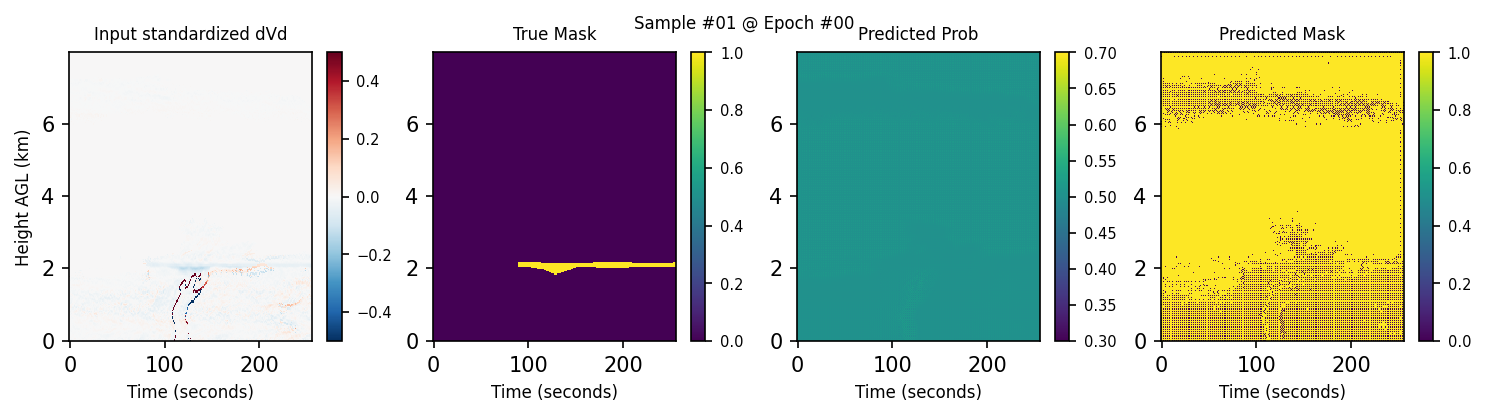

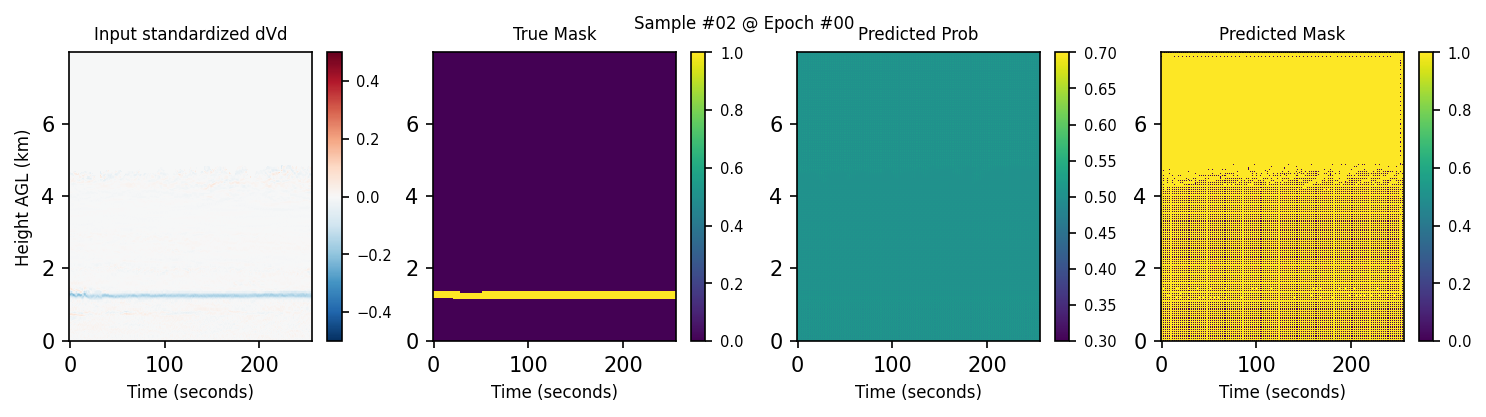

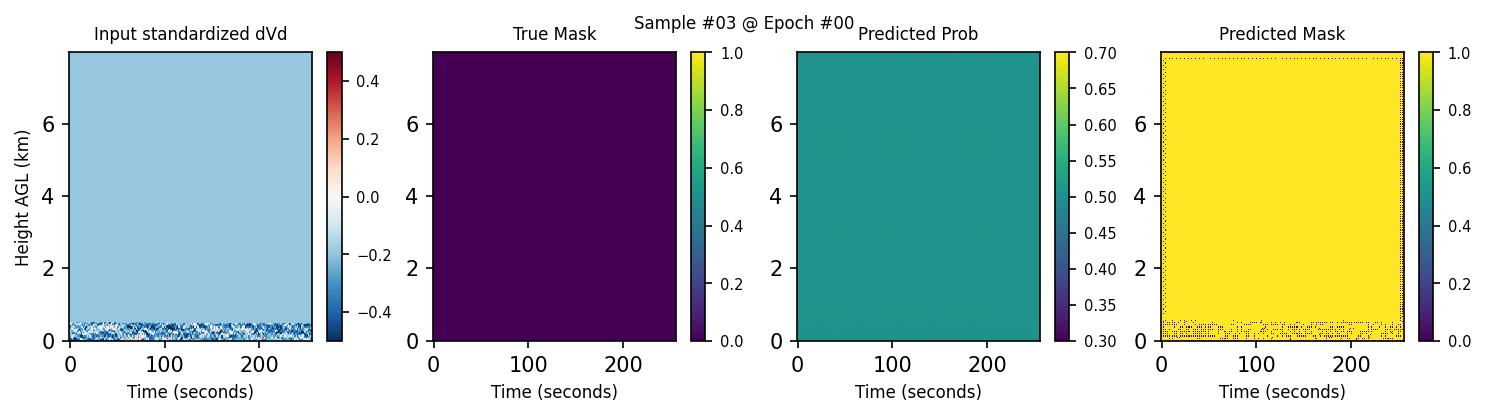

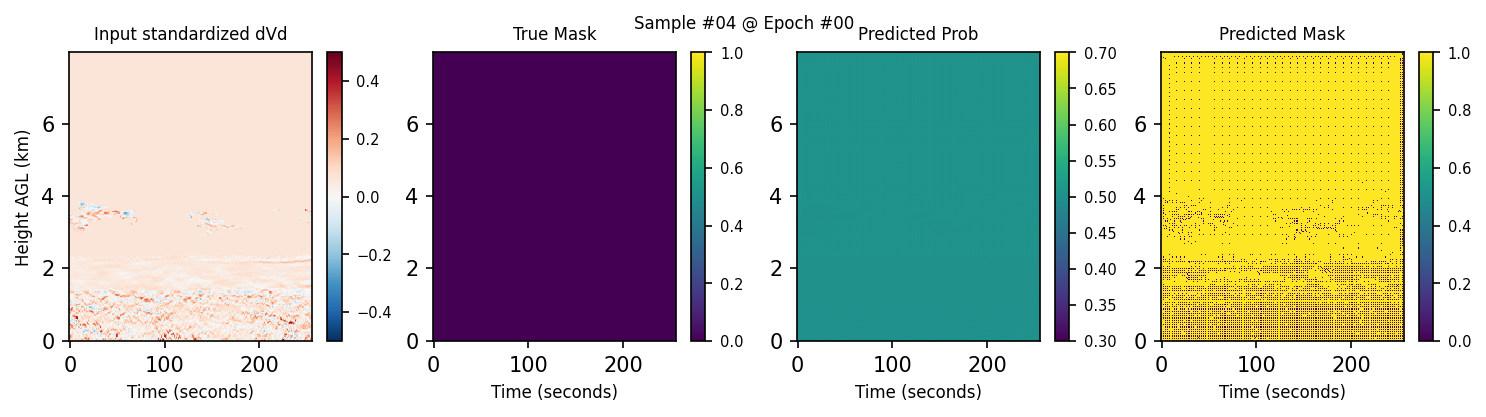

In [19]:
# check the model performance before training
sample_predict = model_unet.predict(sample_input)
display(iepoch=0, data_input=sample_input, data_target=sample_target, data_predict=sample_predict)


Finally, with everything set up we run the training loop.

In [20]:
history = History()
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath=fpathout+'bestmodel.keras', save_best_only=True, mode='auto')
callbacks_unet = [earlyStop, checkpoint, history]

model_unet.fit(train_input, train_target, epochs=N_EPOCHS, batch_size=N_BATCH, \
                 validation_data=(val_input, val_target), shuffle=True, callbacks=callbacks_unet)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - biacc: 0.7248 - dice_coef: 0.2249 - iou: 0.2041 - loss: 0.9455 - val_biacc: 0.5929 - val_dice_coef: 0.1913 - val_iou: 0.1836 - val_loss: 0.9706
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - biacc: 0.9777 - dice_coef: 0.4997 - iou: 0.4424 - loss: 0.7592 - val_biacc: 0.9382 - val_dice_coef: 0.2851 - val_iou: 0.2460 - val_loss: 0.8847
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 332ms/step - biacc: 0.9831 - dice_coef: 0.4583 - iou: 0.3968 - loss: 0.7191 - val_biacc: 0.9858 - val_dice_coef: 0.3785 - val_iou: 0.3394 - val_loss: 0.7229
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - biacc: 0.9855 - dice_coef: 0.4559 - iou: 0.3980 - loss: 0.6668 - val_biacc: 0.9889 - val_dice_coef: 0.4103 - val_iou: 0.3678 - val_loss: 0.6835
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - biacc: 0.9896 - dice_coef: 0.4910 - iou: 0.4314 - loss: 0.6662 - val_biacc: 0.9898 - val_dice_coef: 0.4735 - val_iou: 0.4295 - val_loss: 0.6818
Restoring mo

Now after the model is trained, we once again show predictions on sample cases. For pratical use, the model needs to be trained for more epochs to improve its performance.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


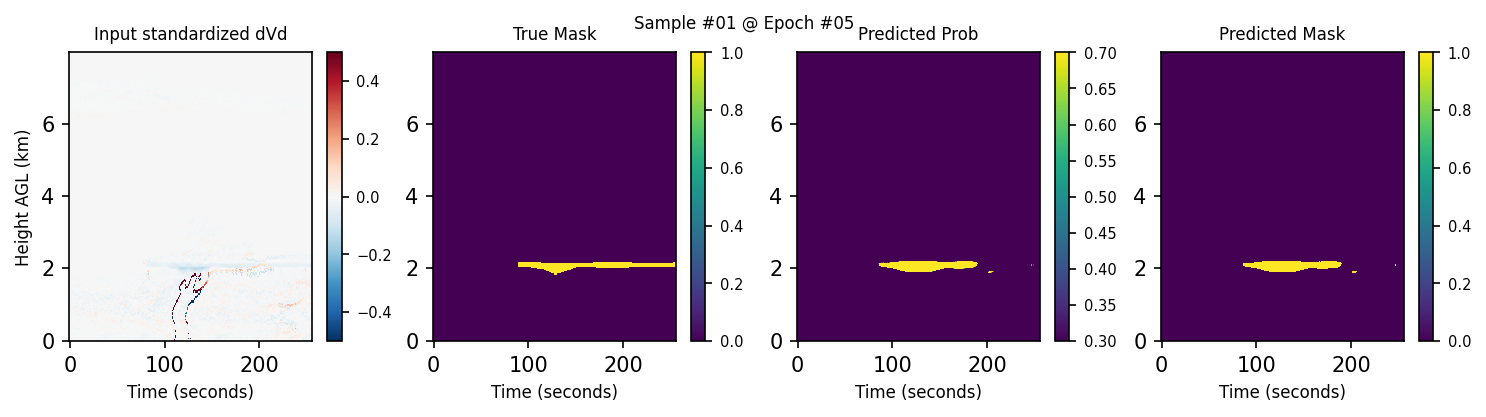

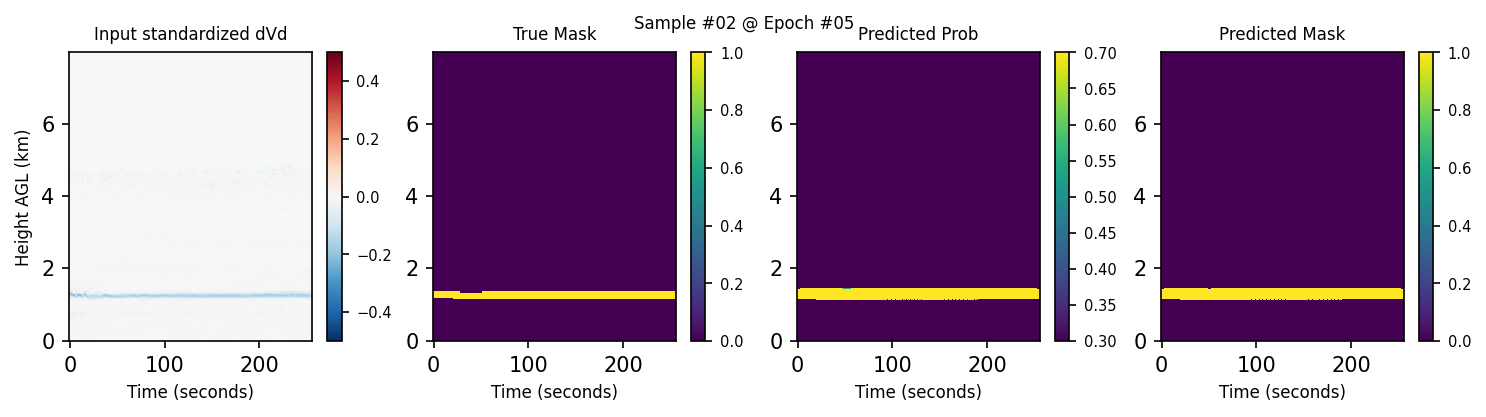

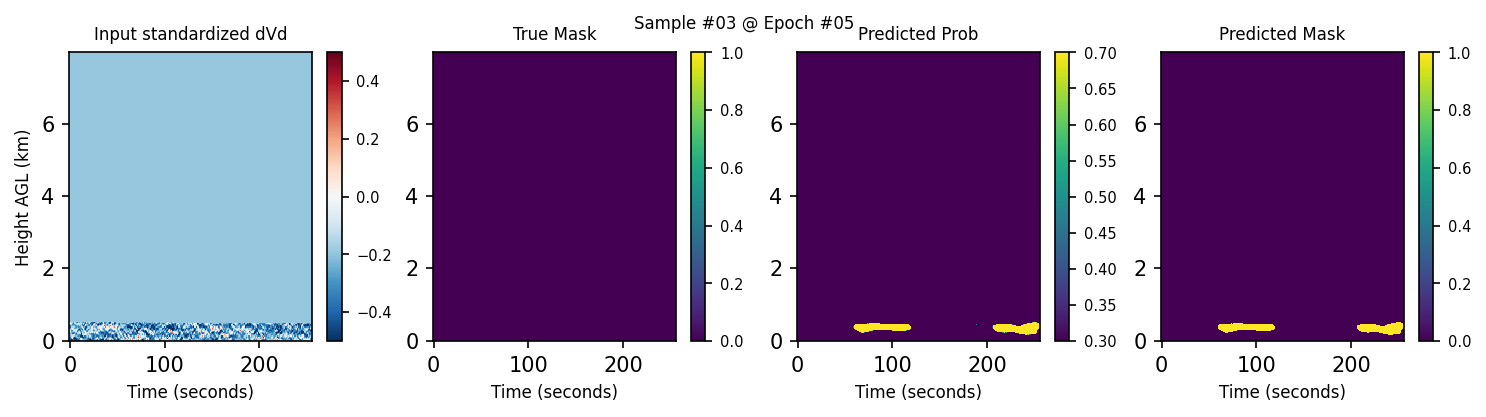

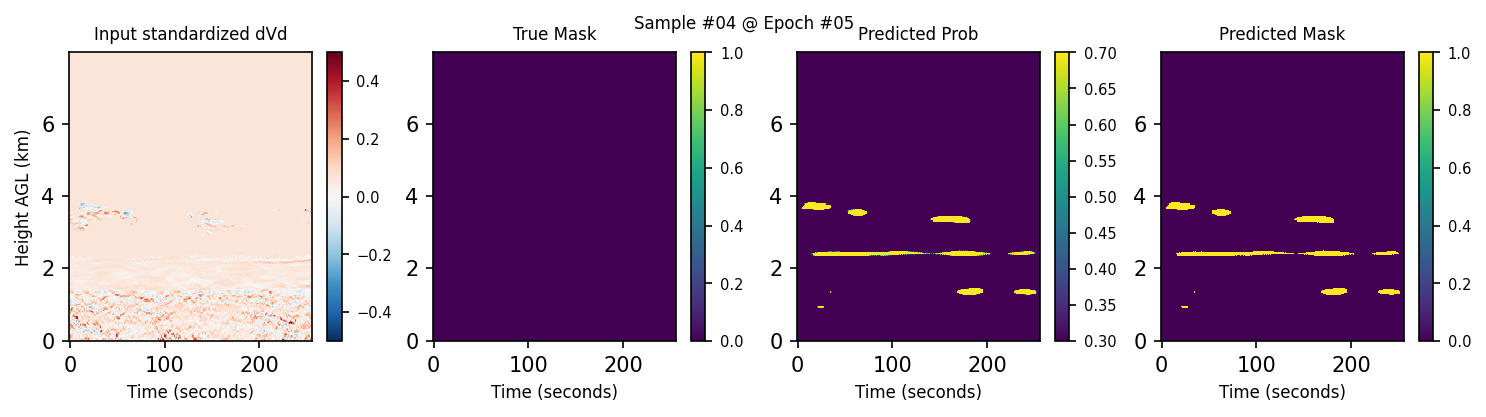

In [21]:
# now check the predictions on sample cases after training for 5 epoches
sample_predict = model_unet.predict(sample_input)
display(iepoch=N_EPOCHS, data_input=sample_input, data_target=sample_target, data_predict=sample_predict)